# CNN i over-sampling

In [1]:
import os
import cv2
import glob
import fnmatch
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import imblearn
import seaborn as sns # Paket za crtanje countplotova(vizuelno predstavljanje klasa kod nebalansiranosti)

In [4]:
from keras import backend as K
from keras import utils
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D, BatchNormalization
from keras.optimizers import Adam

Using TensorFlow backend.
C:\Users\pc\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\pc\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\pc\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\pc\anaconda3\lib\site-packages\tensorboard\compat\tensorflo

In [32]:
def plot(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    
    epochs = history.epoch
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    plt.title('LOSS')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(epochs,loss,c='red',label='training')
    plt.plot(epochs,validation_loss,c='blue',label='validation')
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    
    acc = history.history['f1_m']
    acc_val = history.history['val_f1_m']
    plt.title('F1')
    plt.xlabel('epochs')
    plt.ylabel('f1')
    plt.plot(epochs,acc,c='red',label='training')
    plt.plot(epochs,acc_val,c='blue',label='validation')
    plt.legend(loc='best')
    
    plt.show()

### Učitavanje  podataka

In [5]:
imagePatches = glob.glob('C:/Users/pc/Desktop/data/**/*.png', recursive=True)

In [7]:
patternZero = '*class0.png'
patternOne = '*class1.png'

In [8]:
classZero = fnmatch.filter(imagePatches, patternZero) 
classOne = fnmatch.filter(imagePatches, patternOne)

In [9]:
def load_images(lowerIndex,upperIndex):
    x = []
    y = []
    width = 50
    height = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        image = cv2.imread(img)
        x.append(cv2.resize(image, (width,height), interpolation=cv2.INTER_CUBIC)) # sve slike moraju biti istih dim 
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [10]:
X,y = load_images(0,40000)

In [11]:
X = np.array(X)
y = np.array(y)

### Podela podataka na train, validacioni i test skup

In [12]:
X_train_validation,X_test,y_train_validation,y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = y)

In [13]:
X_train,X_validation,y_train,y_validation = model_selection.train_test_split(X_train_validation, y_train_validation, test_size = 0.2, random_state = 42, stratify = y_train_validation)

### Normalizacija

In [14]:
X_train = X_train.astype('float32')
X_train = X_train/255

In [15]:
X_validation = X_validation.astype('float32')
X_validation = X_validation/255

In [16]:
X_test = X_test.astype('float32')
X_test = X_test/255

### Nebalansiranost klasa

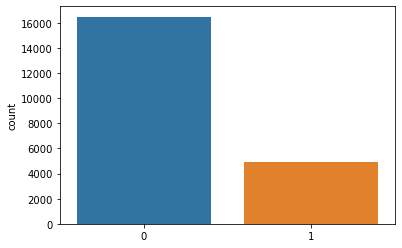

In [17]:
np.bincount(y_train)
sns.countplot(y_train)
plt.show()

In [18]:
X_train.shape

(21440, 50, 50, 3)

In [19]:
X_shape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_train = X_train.reshape(X_train.shape[0], X_shape)

In [20]:
ros = imblearn.over_sampling.RandomOverSampler(random_state = 0,sampling_strategy = 'auto')
X_train, y_train = ros.fit_sample(X_train, y_train)

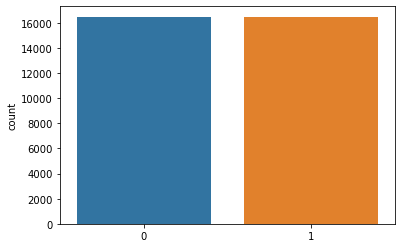

In [21]:
sns.countplot(y_train)
plt.show()

In [22]:
X_train = X_train.reshape(X_train.shape[0],50,50,3)

In [23]:
X_train.shape

(32968, 50, 50, 3)

In [24]:
X_validation.shape

(5360, 50, 50, 3)

In [25]:
X_test.shape

(13200, 50, 50, 3)

### One-hot kodiranje ciljne promenljive

In [26]:
number_of_classes = len(np.unique(y_train))
y_train_oneHot = utils.to_categorical(y_train, number_of_classes)
y_validation_oneHot = utils.to_categorical(y_validation, number_of_classes)
y_test_oneHot = utils.to_categorical(y_test,number_of_classes)

### Kreiranje i treniranje mreže 

In [27]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [28]:
input_shape = (50,50,3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(number_of_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[f1_m])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5120128   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)             

In [ ]:
# mrezu sam trenirala na 10 epoha zato sto je jako spora

In [29]:
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train_oneHot, epochs = epochs, batch_size = batch_size, validation_data = (X_validation, y_validation_oneHot))


Train on 32968 samples, validate on 5360 samples
Epoch 1/10
32968/32968 [==============================] - 335s 10ms/step - loss: 0.4804 - f1_m: 0.7843 - val_loss: 0.4096 - val_f1_m: 0.7948
Epoch 2/10
32968/32968 [==============================] - 313s 9ms/step - loss: 0.4040 - f1_m: 0.8252 - val_loss: 0.3879 - val_f1_m: 0.8196
Epoch 3/10
32968/32968 [==============================] - 337s 10ms/step - loss: 0.3673 - f1_m: 0.8430 - val_loss: 0.3413 - val_f1_m: 0.8449
Epoch 4/10
32968/32968 [==============================] - 348s 11ms/step - loss: 0.3259 - f1_m: 0.8649 - val_loss: 0.3713 - val_f1_m: 0.8438
Epoch 5/10
32968/32968 [==============================] - 358s 11ms/step - loss: 0.2754 - f1_m: 0.8878 - val_loss: 0.4052 - val_f1_m: 0.8340
Epoch 6/10
32968/32968 [==============================] - 358s 11ms/step - loss: 0.2271 - f1_m: 0.9079 - val_loss: 0.4385 - val_f1_m: 0.8297
Epoch 7/10
32968/32968 [==============================] - 342s 10ms/step - loss: 0.1911 - f1_m: 0.9252 - 

### Evaluacija mreže

In [30]:
model.metrics_names

['loss', 'f1_m']

In [ ]:
# mislim da bi ovde trebalo da se proba sa vecim leaning_rate 
# mreza dobro uci jer jos opada greska na trening skupu ali ne generalizuje dobro 
# verovatno je potrebno vise epoha da bi se  videlo da li moze bolje da generalizuje 
# i hoce li se tacnost povecati na validacionom skupu

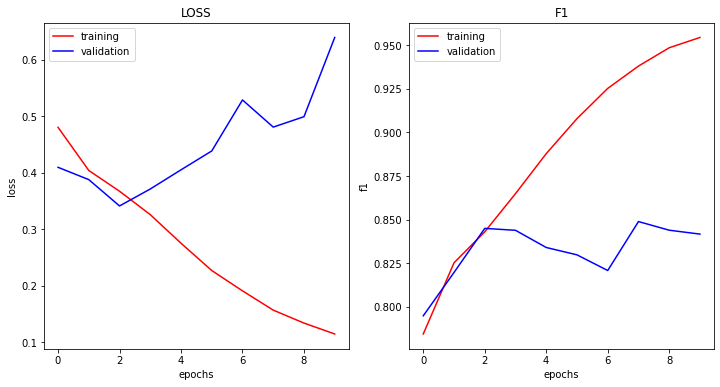

In [38]:
plot(history)

In [35]:
score_train = model.evaluate(X_train,y_train_oneHot, verbose = 0) 

In [36]:
print('loss_train:{:.2f}, f1_score_train: {:.2f}' .format(score_train[0],score_train[1]))

loss_train:0.06, f1_score_train: 0.98


In [37]:
score_test = model.evaluate(X_test,y_test_oneHot, verbose = 0)

In [57]:
print('loss_test:{:.2f}, f1_score_test: {:.2f}' .format(score_test[0],score_test[1]))

loss_test:0.66, f1_score_test: 0.83


In [41]:
y_pred = model.predict(X_test)

In [43]:
y_pred = np.argmax(y_pred, axis = 1)

In [44]:
m = confusion_matrix(y_test,y_pred)
print(m)

[[8717 1431]
 [ 750 2302]]


In [45]:
r = classification_report(y_test,y_pred)
print(r)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89     10148
           1       0.62      0.75      0.68      3052

    accuracy                           0.83     13200
   macro avg       0.77      0.81      0.78     13200
weighted avg       0.85      0.83      0.84     13200



In [60]:
accuracy = metrics.accuracy_score(y_test,y_pred)
print('auc_score modela: {:.2f}' .format(accuracy))

auc_score modela: 0.83


In [61]:
f1 = metrics.f1_score(y_test,y_pred)
print('auc_score modela: {:.2f}' .format(f1))

auc_score modela: 0.68


In [46]:
auc_score = metrics.roc_auc_score(y_test,y_pred)
print('auc_score modela: {:.2f}' .format(auc_score))

auc_score modela: 0.81


### Čuvanje modela

In [59]:
model.save('models/sample_model.h5')